<a href="https://colab.research.google.com/github/mingyu1021/AI-class/blob/main/11week/WISDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# 1. 데이터 로드 및 전처리

column_names = ['sample_id', 'user_id', 'activity', 'timestamp', 'x', 'y', 'z']
df = pd.read_csv('/content/drive/MyDrive/AI-class/WISDM.csv', header=None, names=column_names)
df

,sample_id,user_id,activity,timestamp,x,y,z
0,0,33,Jogging,4.910600e+13,-0.694638,12.680544,0.503953
1,1,33,Jogging,4.910610e+13,5.012288,11.264028,0.953424
2,2,33,Jogging,4.910610e+13,4.903325,10.882658,-0.081722
3,3,33,Jogging,4.910620e+13,-0.612916,18.496431,3.023717
4,4,33,Jogging,4.910630e+13,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...,...
625229,625230,12,Jogging,1.750080e+13,-6.630000,19.570000,-2.260000
625230,625231,12,Jogging,1.750090e+13,-6.970000,19.500000,2.180000
625231,625232,12,Jogging,1.750100e+13,6.430000,14.900000,-5.050000
625232,625233,12,Jogging,1.750100e+13,-0.930000,-2.530000,0.890000


In [11]:
# --- 2. 데이터 필터링 및 클래스 정의 ---

# 요청사항: 'Jogging'(정상)과 'Walking'(이상) 데이터만 사용
df_filtered = df[df['activity'].isin(['Jogging', 'Walking'])].copy()

# 'Jogging' = 0 (정상), 'Walking' = 1 (이상)으로 'Class' 컬럼 생성
df_filtered['Class'] = df_filtered['activity'].apply(lambda x: 0 if x == 'Jogging' else 1)

print(f"\n--- 2. 데이터 필터링 완료 (Jogging=0, Walking=1) ---")
print(df_filtered['Class'].value_counts())


--- 2. 데이터 필터링 완료 (Jogging=0, Walking=1) ---
Class
1    234233
0    200981
Name: count, dtype: int64


In [15]:
# --- 3. 피처 선택 및 스케일링 ---

# 사용할 피처(x, y, z)와 정답(Class)만 남깁니다.
# 'user_id'(subject), 'timestamp' 등은 여기서 제거됩니다.
data = df_filtered[['x', 'y', 'z', 'Class']].copy()

# 결측치 확인 (사용자 요청 사항)
if data.isnull().values.any():
    print("\n[!] 결측치가 발견되어 제거합니다.")
    data = data.dropna()
else:
    print("\n--- 3. 결측치 없음 확인 ---")

# 피처 스케일링 (신용카드 데이터의 'Amount' 스케일링과 동일한 로직)
scaler = StandardScaler()
features = ['x', 'y', 'z']
data[features] = scaler.fit_transform(data[features])

print("피처 스케일링 완료 (x, y, z)")
print(data.head())


[!] 결측치가 발견되어 제거합니다.
피처 스케일링 완료 (x, y, z)
          x         y         z  Class
0 -0.225872  0.698663  0.110903      0
1  0.546809  0.505869  0.203588      0
2  0.532056  0.453963 -0.009868      0
3 -0.214808  1.490229  0.630499      0
4 -0.292260  0.620804  1.492747      0


In [17]:
RANDOM_SEED = 42

In [18]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED, stratify=data['Class'])
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(160784, 3)

In [19]:
# 오토인코더 모델

input_dim = X_train.shape[1]
encoding_dim = 14  # 인코딩 차원을 설정 (임의로 설정한 값, 조정 가능)

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 3. 모델 학습
# 훈련데이터의 0.1 을 validation data로 사용
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_split = 0.1)

Epoch 1/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.4858 - val_loss: 1.0248
Epoch 2/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0181 - val_loss: 1.0087
Epoch 3/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0128 - val_loss: 1.0079
Epoch 4/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0152 - val_loss: 1.0076
Epoch 5/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0127 - val_loss: 1.0075
Epoch 6/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0100 - val_loss: 1.0073
Epoch 7/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0155 - val_loss: 1.0073
Epoch 8/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0178 - val_loss: 1.0072
Epoch 9/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0237 - val_loss: 1.0071
Epoch 10/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0116 - val_loss: 1.0069
Epoch 11/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0157 - val_loss: 1.0068
Epoch 12/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

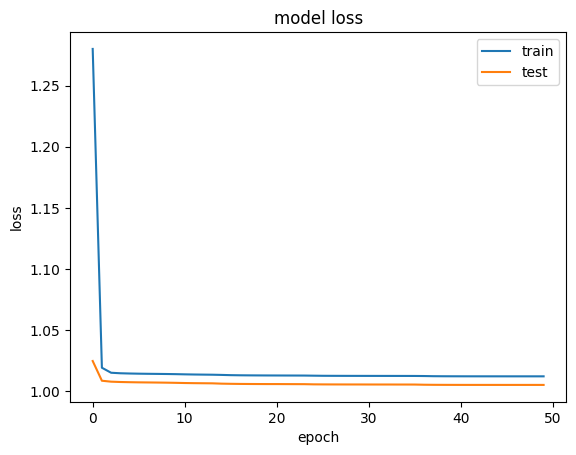

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [21]:
# X_test 값을 넣어서 Reconstruction Error 값을 얻고,
# 실제 레이블인 y_test와 데이터프레임으로 구성
# Reconstruction Error + 실제 레이블의 형태가 됨

predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

2721/2721 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


,reconstruction_error,true_class
count,8.704300e+04,87043.000000
mean,5.941565e-01,0.538205
std,9.590849e-01,0.498541
min,5.365240e-07,0.000000
25%,5.730619e-02,0.000000
50%,2.363529e-01,1.000000
75%,6.898621e-01,1.000000
max,1.026805e+01,1.000000
